In [73]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import sample
from copy import deepcopy
import concurrent.futures

plt.style.use('seaborn-v0_8')

## Step 1
Import data and make some exploratory analysis. Distance is normalized to the average, Population is normalized to the total population

In [2]:
cities = pd.read_csv('cityData.dat', header=None, sep='\t', index_col=0, names=['City', 'Population', 'Latitude', 'Longitude'])
cities.head()

,City,Population,Latitude,Longitude
0,Berlin,0.170716,52.52,13.38
1,Hamburg,0.087981,53.55,10.00
2,Munich,0.067102,48.14,11.58
3,Cologne,0.050797,50.95,6.97
4,Frankfurt,0.033703,50.12,8.68


In [3]:
cities.shape

(40, 4)

In [4]:
distances = pd.read_csv('cityDistances.dat', sep='\t', header= None, names=['Origin','Destiny','Distance'])
distances.head()

,Origin,Destiny,Distance
0,0,1,5.084382
1,0,2,10.082311
2,0,3,9.523469
3,0,4,8.456714
4,0,5,10.201078


In [5]:
distances.shape

(780, 3)

### Step 1.5
Try to define a graph with the data 

In [50]:
# This two dictionaries are going to be global variabes, used below in the code, don't change them
delta = 1/3
Nodes = [(i,cities.to_dict(orient='records')[i]) for i in range(cities.shape[0])]
Edges = [(distances.iloc[i,0],distances.iloc[i,1],{'weight': distances.iloc[i,2], 
                                                   'eff_dist': (1-delta)*distances.iloc[i,2] + delta}) for i in range(distances.shape[0])]

In [7]:
def Change_delta_in_edges(delta, edges=Edges):
    edges = [(distances.iloc[i,0],distances.iloc[i,1],{'weight': distances.iloc[i,2], 
                                                       'eff_dist': (1-delta)*distances.iloc[i,2] + delta}) for i in range(distances.shape[0])]
    return edges

In [8]:
print(Nodes[:3])
print(Edges[:3])

[(0, {'City': 'Berlin', 'Population': 0.1707159963294827, 'Latitude': 52.52, 'Longitude': 13.38}), (1, {'City': 'Hamburg', 'Population': 0.0879805435806981, 'Latitude': 53.55, 'Longitude': 10.0}), (2, {'City': 'Munich', 'Population': 0.0671020343799828, 'Latitude': 48.14, 'Longitude': 11.58})]
[(0, 1, {'weight': 5.084381891841052, 'eff_dist': 3.7229212612273686}), (0, 2, {'weight': 10.082311312508343, 'eff_dist': 7.054874208338896}), (0, 3, {'weight': 9.523468735599538, 'eff_dist': 6.682312490399692})]


In [9]:
Edges_2 = Change_delta_in_edges(2/3)
print(Nodes[:3])
print(Edges_2[:3])

[(0, {'City': 'Berlin', 'Population': 0.1707159963294827, 'Latitude': 52.52, 'Longitude': 13.38}), (1, {'City': 'Hamburg', 'Population': 0.0879805435806981, 'Latitude': 53.55, 'Longitude': 10.0}), (2, {'City': 'Munich', 'Population': 0.0671020343799828, 'Latitude': 48.14, 'Longitude': 11.58})]
[(0, 1, {'weight': 5.084381891841052, 'eff_dist': 2.361460630613684}), (0, 2, {'weight': 10.082311312508343, 'eff_dist': 4.027437104169448}), (0, 3, {'weight': 9.523468735599538, 'eff_dist': 3.841156245199846})]


In [10]:
## Possible useful lists for a general graph
# edges = list(graph.edges) # list of tuples
# nodes = list(graph.nodes) 
# weights = [graph.get_edge_data(i[0],i[1],default=0)['weight'] for i in edges]

In [11]:
# This is a preliminary complete graph
G = nx.Graph()
G.add_nodes_from(Nodes)
G.add_edges_from(Edges)

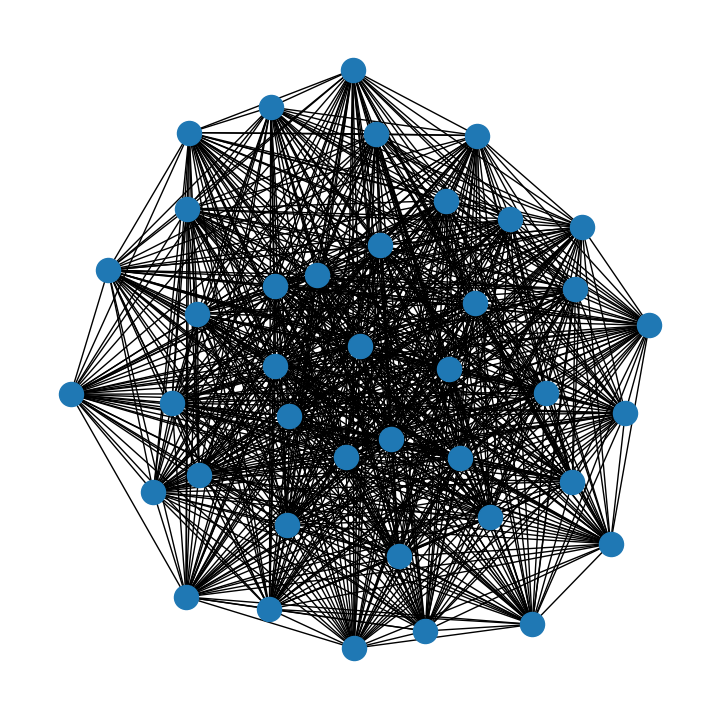

In [12]:
plt.figure(figsize=(7,7))
nx.draw(G)
plt.show()

In [13]:
# p = dict(nx.shortest_path_length(G, weight='weight'))
# [p[0][i] for i in range(cities.shape[0])]

# p = nx.shortest_path_length(G, source=0, target=13, weight='weight')
# p

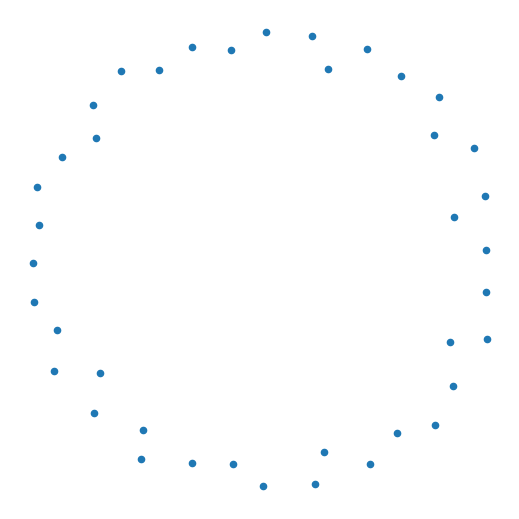

In [14]:
G0 = nx.Graph()
G0.add_nodes_from(Nodes)

G1 = G0.copy()
G1.add_edge(0,5,weight=1.2)

plt.figure(figsize=(5,5))
nx.draw(G0, node_size=20)
plt.show()

## Step 2
Define the cost functions
$$C_{tot} = C_{infra} + \gamma C_{trans}$$
$$C_{infra} = \sum_{e_{ij}\in E}d(e_{ij}) $$
$$C_{trans} = \frac{1}{2} \sum_{i,j \in V} P_i P_j ~ \tilde{d}_{ji} $$

Where $ \tilde{d}_{ji}$ is defined by

$$ \tilde{d}(e_{ij}) = (1-\delta) d(e_{ij}) + \delta $$

In [15]:
def C_infra(graph, paths=None):
    if paths is None:
        paths = dict(nx.shortest_path_length(graph, weight='weight'))

    num_nodes = len(graph.nodes)
    shortest_path_lengths = np.zeros((num_nodes, num_nodes))
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            shortest_path_lengths[i][j] = paths[i].get(j, np.Inf)

    return 0.5 * np.sum(shortest_path_lengths)

In [16]:
C_infra(G)

4445.97350006116

In [17]:
def C_trans(graph, eff_paths=None, Pop=None):
    if eff_paths is None:
        eff_paths = dict(nx.shortest_path_length(graph, weight='eff_dist'))
    if Pop is None:
        Pop = nx.get_node_attributes(graph, name='Population')

    nodes = list(eff_paths.keys())
    sum_ = 0
    for i in nodes:
        for j in nodes:
            sum_ += Pop[i] * Pop[j] * eff_paths[i].get(j)
    return 0.5 * sum_

In [18]:
C_trans(G)

2.183314505485115

In [35]:
def C_tot(graph, γ, paths=None, eff_paths=None,Pop=None):
    if paths is None:
        paths = dict(nx.shortest_path_length(graph, weight='weight'))
    if eff_paths is None:
        eff_paths = dict(nx.shortest_path_length(graph, weight='eff_distance'))
    if Pop is None:
        Pop = nx.get_node_attributes(graph, name='Population')

    infra_cost = C_infra(graph, paths)
    trans_cost = C_trans(graph, eff_paths, Pop)
    total_cost = infra_cost + (γ * trans_cost)

    return total_cost

In [36]:
gamma = 200
print(C_infra(G)) # This is going to be large, because G is a complete network
print(C_trans(G))
print(C_trans(G)*gamma)
print(C_tot(G,gamma))

4445.97350006116
2.183314505485115
436.662901097023
4540.307123654287


## Step 3

Implement the Metropolis algorithm. Start with a complete graph and start removing and adding edges to see if the cost function is reduced.

In [52]:
distances_dict = distances.to_dict(orient='records')

def get_distance(origin, destiny, distances=distances_dict):
    for item in distances:
        if item['Origin'] == origin and item['Destiny'] == destiny:
            return item['Distance']
        elif item['Destiny'] == origin and item['Origin'] == destiny:
            return item['Distance']
    return None   

# Add proper weigths to the edges
def Add_Weights_to_Edge(graph,i,j,delta):    
    d_ij = get_distance(i,j)
    graph[i][j]['weight'] = d_ij
    graph[i][j]['eff_dist'] = (1-delta)*d_ij+delta
    return graph

In [22]:
def Metropolis_step(graph, γ, delta,T=1):
    link = sample(list(graph.nodes), 2)  
    while link[0] == link[1]:
        link = sample(list(graph.nodes), 2)
    
    pop = nx.get_node_attributes(graph, name='Population')
    old_cost = C_tot(graph, γ, Pop=pop)
    
    if graph.has_edge(*link):
        graph.remove_edge(*link)
    else:
        graph.add_edge(*link)
        graph = Add_Weights_to_Edge(graph,link[0],link[1],delta)
    
    new_cost = C_tot(graph, γ, Pop=pop)
    ΔC = new_cost - old_cost
    
    if ΔC < 0 or np.exp(-ΔC / T) < 1:
        return graph, new_cost
    else:
        if graph.has_edge(*link):
            graph.remove_edge(*link)
        else:
            graph.add_edge(*link)
            print(list(graph.edges))
            graph = Add_Weights_to_Edge(graph,link[0],link[1],delta)
        return graph, old_cost

In [23]:
def process_delta(del_val, gamma, T_values, N, G):
    costs = []
    G2 = deepcopy(G)
    for temp_idx, temp in enumerate(T_values):
        for _ in range(N):
            G2, graph_cost = Metropolis_step(G2, gamma, del_val, temp)

        costs.append(graph_cost)
        if temp_idx % 10 == 0:
            print(f"Delta: {del_val}, Temperature: {temp}")
    return del_val, costs, G2

if __name__ == '__main__':
    delta = [0, 1/3, 2/3, 1]
    gamma = 200
    T = np.linspace(10, 0.1, 100)
    N = 50
    costs_delta = []
    last_graph = []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_delta, del_val, gamma, T, N, G) for del_val in delta]
        
        for future in futures:
            del_val, costs, graph = future.result()
            costs_delta.append(costs)
            last_graph.append(graph)
            print(f"Finished processing delta = {del_val}")

    # print(costs_delta)
    # Use or save last_graph as needed

Delta: 0.6666666666666666, Temperature: 10.0
Delta: 0, Temperature: 10.0
Delta: 1, Temperature: 10.0
Delta: 0.3333333333333333, Temperature: 10.0
Delta: 0.6666666666666666, Temperature: 9.0
Delta: 0, Temperature: 9.0
Delta: 1, Temperature: 9.0
Delta: 0.3333333333333333, Temperature: 9.0
Delta: 0, Temperature: 8.0
Delta: 0.6666666666666666, Temperature: 8.0
Delta: 1, Temperature: 8.0
Delta: 0.3333333333333333, Temperature: 8.0
Delta: 0, Temperature: 7.0
Delta: 0.6666666666666666, Temperature: 7.0
Delta: 0.3333333333333333, Temperature: 7.0
Delta: 1, Temperature: 7.0
Delta: 0, Temperature: 6.0
Delta: 0.6666666666666666, Temperature: 6.0
Delta: 0.3333333333333333, Temperature: 6.0
Delta: 1, Temperature: 6.0
Delta: 0, Temperature: 5.0
Delta: 0.6666666666666666, Temperature: 5.0
Delta: 0.3333333333333333, Temperature: 5.0
Delta: 1, Temperature: 5.0
Delta: 0, Temperature: 4.0
Delta: 0.6666666666666666, Temperature: 4.0
Delta: 0.3333333333333333, Temperature: 4.0
Delta: 1, Temperature: 4.0
De

In [24]:
# for del_val in delta:
#     i = 0
#     with open('CompNet_Delta{: .2f}.txt'.format(del_val),'w') as file:
#         for temp,cost in zip(T,costs_delta[i]):
#             file.write(f'{temp}, {cost}\n')
#         i += 1

In [25]:
# for i, graph in enumerate(last_graph):
#     filename = "Graph_delta_{: .2f}_CompNet.adjlist".format(delta[i])
    
#     # Save graph to adjacency list
#     nx.write_adjlist(graph, filename)
#     print(f"Graph {i} (delta = {delta[i]}) saved as adjacency list: {filename}")

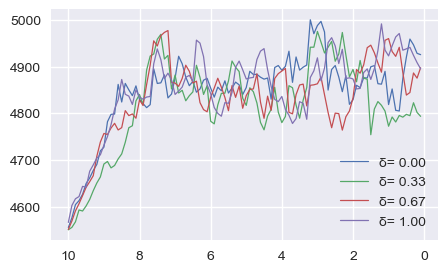

In [26]:
plt.figure(figsize=(5,3))
for i in range(len(delta)):
    plt.plot(T,costs_delta[i],lw=0.9,label='δ={: .2f}'.format(delta[i]))
plt.gca().invert_xaxis()
plt.legend()
plt.show()

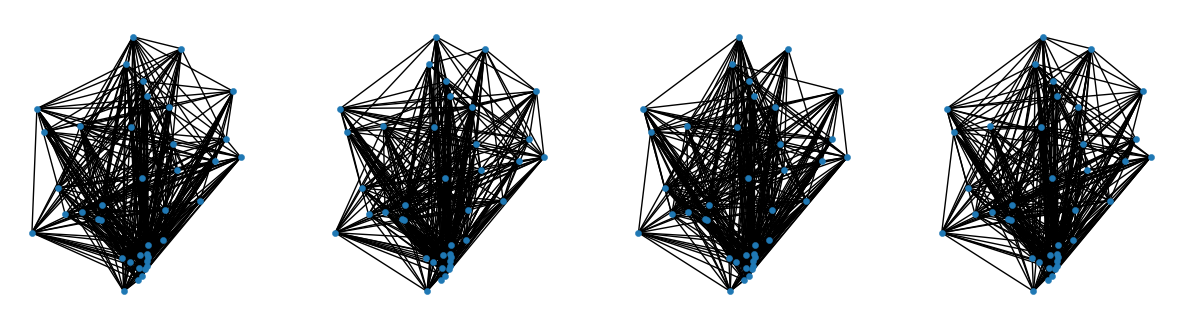

In [27]:
fig, axs = plt.subplots(1,4,figsize=(15,4))
positions = {i:(cities.iloc[i,2],cities.iloc[i,3]) for i in range(cities.shape[0])}
for i in range(4):
    nx.draw(last_graph[i], positions,node_size=20, ax=axs[i])
plt.show()

## Step 4
Try the same sing but starting from random graphs, rather than a conected one

In [55]:
#Remember this functions
get_distance?
Add_Weights_to_Edge?

Signature: Add_Weights_to_Edge(graph, i, j, delta)
Docstring: <no docstring>
File:      c:\users\esteb\appdata\local\temp\ipykernel_13016\1794165610.py
Type:      function

In [64]:
distances_dict = distances.to_dict(orient='records')

def add_random_edge(graph):
    nodes = list(graph.nodes)
    i, j = sample(nodes, 2)
    if graph.has_edge(i, j) is False:
        graph.add_edge(i, j)        
    return graph

def Create_Random_Graph(graph): #The input is a graph with no edges, only nodes 
    k = 0
    while nx.is_connected(graph) is False:
        add_random_edge(graph)
        k += 1
        if k>1000: break #Security check
    return graph

# Add proper weigths to the edges
def Add_Weights(graph,delta):    
    for i,j in list(graph.edges):
        Add_Weights_to_Edge(graph,i,j,delta)
    return graph

def Make_RandomGraph_with_Weigths(graph,delta):
    graph = Create_Random_Graph(graph)
    graph = Add_Weights(graph,delta)
    return graph    

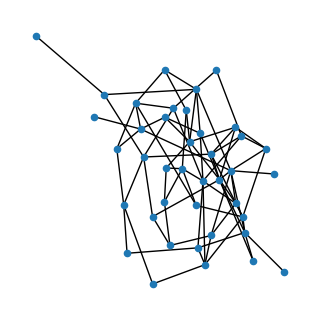

In [65]:
delta = 1/3
G_r0 = deepcopy(G0)
G_r0 = Make_RandomGraph_with_Weigths(G_r0,delta)

plt.figure(figsize=(3,3))
nx.draw(G_r0, node_size=20)
plt.show()

In [66]:
i = 0
for node1, node2, data in G_r0.edges(data=True):
    print(i,data)
    i += 1

0 {'weight': 9.515431196029692, 'eff_dist': 6.676954130686461}
1 {'weight': 10.082311312508343, 'eff_dist': 7.054874208338896}
2 {'weight': 10.819447756884296, 'eff_dist': 7.546298504589531}
3 {'weight': 5.872300982718972, 'eff_dist': 4.248200655145982}
4 {'weight': 3.018028199595319, 'eff_dist': 2.3453521330635465}
5 {'weight': 10.05567290911972, 'eff_dist': 7.0371152727464805}
6 {'weight': 9.843792979581565, 'eff_dist': 6.89586198638771}
7 {'weight': 9.76727558308341, 'eff_dist': 6.844850388722274}
8 {'weight': 10.221324820265911, 'eff_dist': 7.147549880177275}
9 {'weight': 1.3032539558614142, 'eff_dist': 1.2021693039076096}
10 {'weight': 1.0305583927207462, 'eff_dist': 1.020372261813831}
11 {'weight': 0.9513528766681432, 'eff_dist': 0.9675685844454289}
12 {'weight': 5.772179090600176, 'eff_dist': 4.181452727066784}
13 {'weight': 3.874194746141818, 'eff_dist': 2.9161298307612125}
14 {'weight': 5.925944813349138, 'eff_dist': 4.283963208899426}
15 {'weight': 5.284436126414609, 'eff_dis

Try to see if the code still works with this graph

In [68]:
test_costs = []
delta = [0, 1/3, 2/3, 1]
gamma = 200
Temperatures = np.linspace(10, 0.1, 100)
N_per_temp = 50

for t in Temperatures:
    for i in range(N_per_temp):
        G_r0, cost = Metropolis_step(G_r0, gamma, delta[1], T=t)
    test_costs.append(cost)

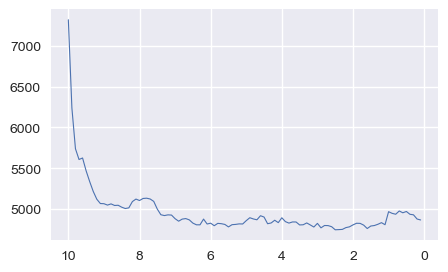

In [75]:
plt.figure(figsize=(5,3))

plt.plot(Temperatures,test_costs, lw=0.8)

plt.gca().invert_xaxis()
plt.show()

Ok, it works, now let's make an ensemble of 50 random graphs and for δ = 1/3, try to find the minimum cost graph, and an average of the cost fucntion

In [30]:
# RandGraph_ensemble = []
# for _ in range(50):
#     G_r0 = deepcopy(G0)
#     G_r0 = Make_RandomGraph_with_Weigths(G_r0)
#     RandGraph_ensemble.append(G_r0)